<a href="https://colab.research.google.com/github/mdaugherity/MachineLearning2024/blob/main/tutorial/Tutorial_15_Boosted_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dr. Daugherity, Abilene Christian University, PHYS 453**

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap # for making palettes

# Common utilities
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import ConfusionMatrixDisplay

# Classifiers
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

# Tutorial 15: Boosted Trees

Since this is an important classifier, here's a quick demo of usable code.  There are many good reasons to use Gradient Boosted Decision Trees:
* powerful: models like [XGBoost](https://xgboost.readthedocs.io/en/stable/#) and [LightGBM](https://github.com/Microsoft/LightGBM) often win contests
* easy to train: no grid search required for great performance
* gives a great baseline to know before you start training a fancy neural network
* easy support for missing data

##Important Note
In sklearn we get two implementations:
1.  **GradientBoostingClassifier** is a bit more accurate (especially for small number of data samples) but slower
1.  **HistGradientBoostingClassifier** is orders of magnitude faster and has built-in support for missing values, but a tiny bit less accurate.  

They are similar but annoyingly different to use. See the Users Guide: https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosted-trees

## Early Stopping
The algorithm in general starts with a simple decision tree then adds new trees trained on the *error*, so the final prediction is a simple sum.  The main parameter is the number of trees (```n_estimators``` or ```max_iter```).  We can enable early stopping to halt the process is error has not improved by ```tol``` within ```n_iter_no_change``` iterations.   Frustratingly, early stopping is controlled differently in the two implementations.

Also note that each new tree is weighted by a learning rate, so increasing the learning rate reduces the number of trees.

##GBC (Slow)
GBC API: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

**GBC Parameters to Know**
* ```n_estimators``` = 100, main parameter, fairly robust to overfitting so a "large number" usually gives better performance
* ```learning_rate``` = 0.1, trade-off between learning_rate and n_estimators.  Each new learner is scaled by learning_rate, so smaller rate needs more learners
* ```n_iter_no_change```=None: turns on early stopping for change greater than tol=1e-4.  10 is a good value to use.  Check n_estimators_ after fitting to find where it stopped
* ```validation_fraction```=0.1, only used in early stopping (n_iter_no_change is set)
* ```tol```=1e-4, only used in early stopping

##HGBC (Fast)
HGBC API: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html

**HGBC Parameters to Know**
* ```max_iter```=100, main parameter, fairly robust to overfitting so a "large number" usually gives better performance
* ```learning_rate``` = 0.1, trade-off between learning_rate and n_estimators.  Each new learner is scaled by learning_rate, so smaller rate needs more learners
* ```early_stopping```='auto', auto enables early stopping when sample size>10k
* ```n_iter_no_change```=10: only used when early stopping
* ```validation_fraction```=0.1, only used if early_stopping
* ```tol```=1e-7: only used if early_stopping

## Training
The recommended approach is easy:
* set ```learning_rate```=0.1
* enable early stopping
* add enough trees so that early stopping happens

##XGBoost
As a final note, if you want the real deal there is a simple wrapper for XGBoost to play nicely with sklearn
```from xgboost.sklearn import XGBClassifier```



# Simple 2D Examples
Let's examine some decision boundaries to get a feel for how these work

## Toy Datasets

In [2]:
# From my Neural Network tutorial
# Generate a few datasets to play with, have to make some modifications to get 2 classes
Xcircle, ycircle = datasets.make_circles()

num_clust = 20
Xclust,yclust = datasets.make_blobs(n_samples=10*num_clust,centers=num_clust,random_state=42)
yclust = np.floor_divide(yclust,num_clust/2) # default is one class per blob, this changes it to 2 classes

Xmoons, ymoons = datasets.make_moons()

Xblobs, yblobs = datasets.make_blobs(n_samples=100,centers=2,random_state=42,cluster_std=4)

# listify
Xdata = (Xblobs,Xclust,Xmoons,Xcircle)
ydata = (yblobs,yclust,ymoons,ycircle)

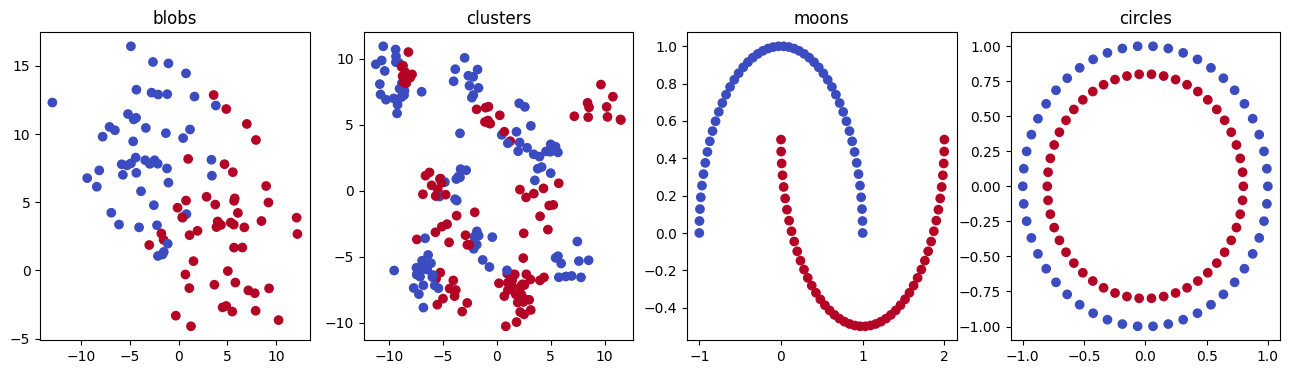

In [3]:
plt.figure(figsize=(16,4))

titles = ('blobs','clusters','moons','circles')
for i,(X,y,title) in enumerate(zip(Xdata,ydata,titles)):
    plt.subplot(1,4,i+1)
    X0 = X[:,0]
    X1 = X[:,1]
    plt.scatter(X0, X1,c=y,cmap='coolwarm')
    plt.title(title)

plt.show()

## GBC Playground
Play around and have fun.  Note that there are a small number of data points so the validation set is small and scores won't be great.

Score:  0.97
n_estimators asked:  500
n_estimators used:   69


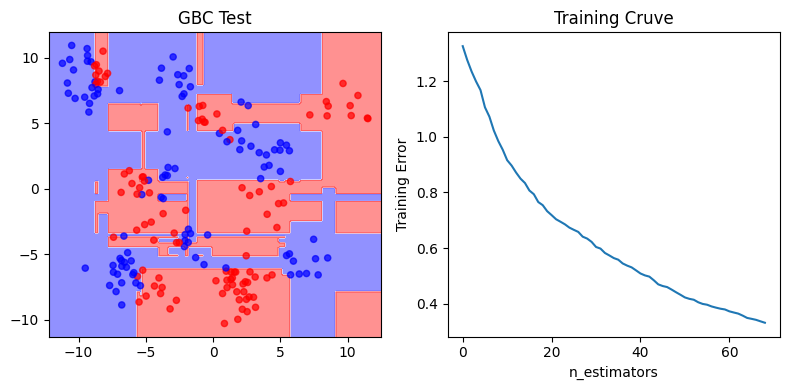

In [19]:
clf = GradientBoostingClassifier(n_estimators=500,learning_rate=0.1, n_iter_no_change=10, tol=1e-7)
X = Xclust # choices are: (Xblobs,Xclust,Xmoons,Xcircle)
y = yclust
clf.fit(X, y)
print('Score: ',clf.score(X,y))
print('n_estimators asked: ', clf.n_estimators)
print('n_estimators used:  ', clf.n_estimators_)

plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
disp = DecisionBoundaryDisplay.from_estimator(clf, X,ax=ax, response_method="predict",alpha=0.5,cmap='bwr',grid_resolution=200)
plt.scatter(X[:,0], X[:,1],c=y,cmap='bwr', alpha=0.7, s=20)
plt.title('GBC Test')

plt.subplot(1,2,2)
plt.plot(clf.train_score_,label='train')
plt.title('Training Cruve')
plt.xlabel('n_estimators')
plt.ylabel('Training Error')

plt.tight_layout()
plt.show()

## HistGBC Playground

Score:  0.995
n_estimators asked:  500
n_estimators used:   500


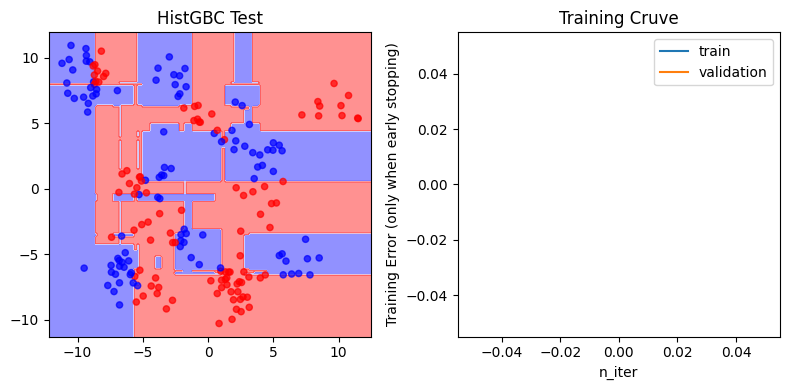

In [22]:
clf = HistGradientBoostingClassifier(max_iter=500,learning_rate=0.1, early_stopping='auto', n_iter_no_change=10, tol=1e-4)
X = Xclust # choices are: (Xblobs,Xclust,Xmoons,Xcircle)
y = yclust
clf.fit(X, y)
print('Score: ',clf.score(X,y))
print('n_estimators asked: ', clf.max_iter)
print('n_estimators used:  ', clf.n_iter_)

plt.figure(figsize=(8,4))

ax = plt.subplot(1,2,1)
disp = DecisionBoundaryDisplay.from_estimator(clf, X,ax=ax, response_method="predict",alpha=0.5,cmap='bwr',grid_resolution=200)
plt.scatter(X[:,0], X[:,1],c=y,cmap='bwr', alpha=0.7, s=20)
plt.title('HistGBC Test')

plt.subplot(1,2,2)
plt.plot(clf.train_score_,label='train')
plt.plot(clf.validation_score_,label='validation')
plt.title('Training Cruve')
plt.xlabel('n_iter')
plt.ylabel('Training Error (only when early stopping)')
plt.legend()

plt.tight_layout()
plt.show()

## Comparisons

1.0
0.99
1.0
0.87


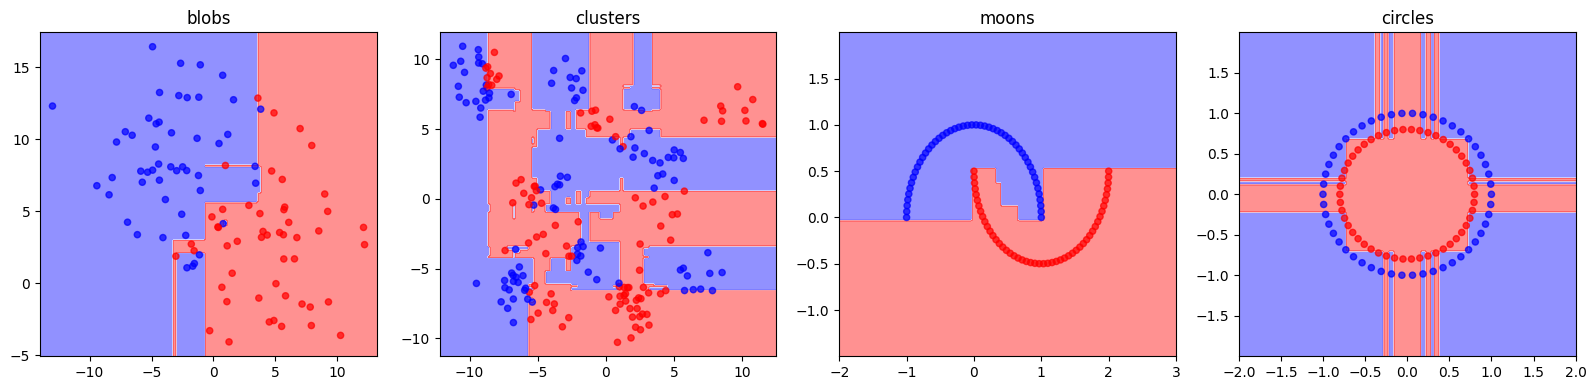

In [6]:
plt.figure(figsize=(16,4))

titles = ('blobs','clusters','moons','circles')
for i,(X,y,title) in enumerate(zip(Xdata,ydata,titles)):
    ax = plt.subplot(1,4,i+1)
    X0 = X[:,0]
    X1 = X[:,1]

    #clf = GradientBoostingClassifier(n_estimators=200,learning_rate=0.1, n_iter_no_change=10)
    clf = HistGradientBoostingClassifier(max_iter=200,learning_rate=0.1)
    clf.fit(X,y)
    print(clf.score(X,y))
    disp = DecisionBoundaryDisplay.from_estimator(clf, X,ax=ax, response_method="predict",alpha=0.5,cmap='bwr',grid_resolution=200)
    plt.scatter(X0, X1,c=y,cmap='bwr', alpha=0.7, s=20)
    plt.title(title)

plt.tight_layout()
plt.show()

## Varying Parameters

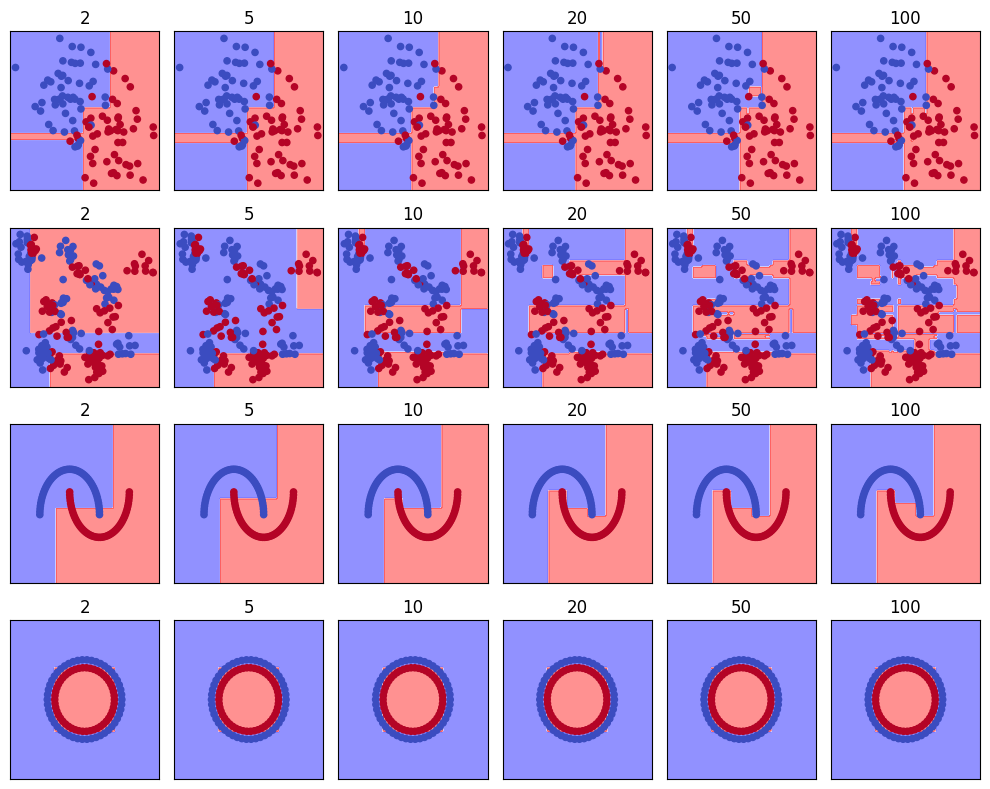

In [7]:
plt.figure(figsize=(10,8))
NLIST = [2, 5, 10, 20, 50, 100]

for i,(X,y) in enumerate(zip(Xdata,ydata)):
    X0 = X[:,0]
    X1 = X[:,1]

    for j,N in enumerate(NLIST):
        ax = plt.subplot(len(Xdata),len(NLIST),len(NLIST)*i+1+j)
        ax.set_title(N)
        ax.set_xticks(())
        ax.set_yticks(())
        clf = GradientBoostingClassifier(n_estimators=N)
        #clf = HistGradientBoostingClassifier(max_iter=N)
        clf.fit(X,y)
        disp = DecisionBoundaryDisplay.from_estimator(clf, X,ax=ax, response_method="predict",alpha=0.5,cmap='bwr')
        plt.scatter(X0, X1, s=20, c=y,cmap='coolwarm')

plt.tight_layout()
plt.show()

## Bigger Problem - Digits

In [9]:
Xdig, ydig = datasets.load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(Xdig, ydig)

In [24]:
clf = HistGradientBoostingClassifier(max_iter=100, early_stopping=True, verbose=0, tol=1e-9)
clf.fit(X_train,y_train)
print('n_estimators asked: ', clf.max_iter)
print('n_estimators used:  ', clf.n_iter_)
print('Train Score: ',clf.score(X_train,y_train))
print(' Test Score: ',clf.score(X_test,y_test))

n_estimators asked:  100
n_estimators used:   49
Train Score:  0.991833704528582
 Test Score:  0.9777777777777777


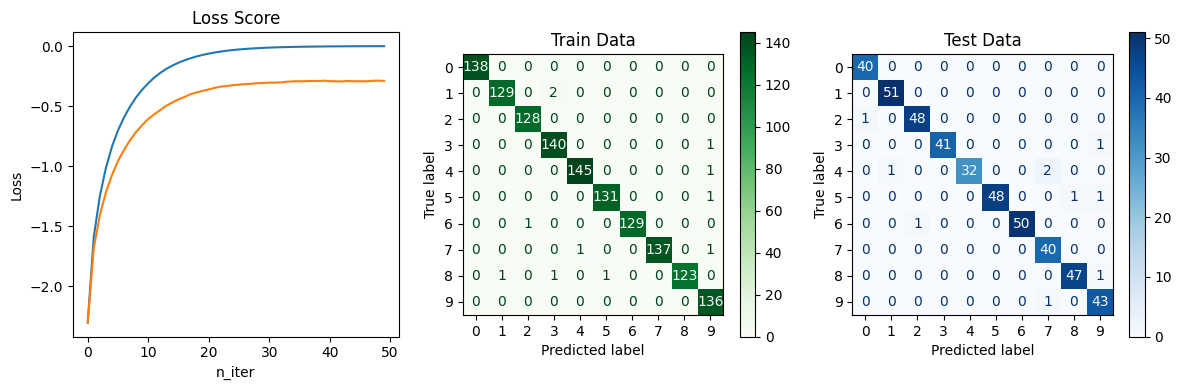

In [34]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(clf.train_score_,label='Train')
plt.plot(clf.validation_score_,label='Validation')
plt.title('Loss Score')
plt.xlabel('n_iter')
plt.ylabel('Loss')

ax = plt.subplot(1,3,2)
disp = ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train,ax=ax, cmap='Greens')
plt.title('Train Data')

ax = plt.subplot(1,3,3)
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,ax=ax, cmap='Blues')
plt.title('Test Data')

plt.tight_layout()
plt.show()

In [35]:
# Find the miss-classified samples
y_pred = clf.predict(X_test)
miss = []  # save missed sample numbers
print('Sample\tTruth\tPredicted')
for i,pred in enumerate(y_pred):
    if pred!=y_test[i]:
        print(f"{i}\t{y_test[i]}\t{pred}")
        miss.append(i)

Sample	Truth	Predicted
24	5	8
37	6	2
58	5	9
69	3	9
221	4	7
291	9	7
300	8	9
407	4	7
418	2	0
426	4	1


In [36]:
len(miss)

10

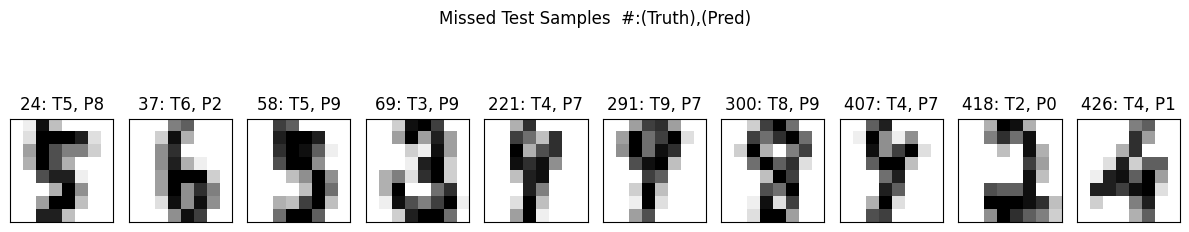

In [39]:
plt.figure(figsize=(12,3))

NUM = 10
for i in range(NUM):
  plt.subplot(1,NUM,i+1)
  ind = miss[i]
  plt.imshow(X_test[ind].reshape(8,8), cmap=plt.cm.binary)
  plt.title(f"{ind}: T{y_test[ind]}, P{y_pred[ind]}")
  plt.xticks(ticks=[])
  plt.yticks(ticks=[])

plt.suptitle('Missed Test Samples  #:(Truth),(Pred)')
plt.tight_layout()
plt.show()